In [51]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import random
from glob import glob
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [44]:
#First, we must define a class that will handle our dataset.

class XRayDataset(Dataset):
    def __init__(self, file_path, img_dir, transform=None, disease_start_idx=2, disease_end_idx=-2, tabular_cols=[1, -1]):
        self.df = pd.read_parquet(file_path)
        self.img_dir = img_dir
        self.transform = transform

        self.image_ids = self.df['image_id'].values
        self.labels = torch.tensor(
            self.df.iloc[:, disease_start_idx:disease_end_idx].values,
            dtype=torch.float32
        )

        self.tabular_features = torch.tensor(
            self.df.iloc[:, tabular_cols].values,
            dtype=torch.float32
        )


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.image_ids[idx])
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        tab_features = self.tabular_features[idx]
        label = self.labels[idx]


        return image, tab_features, label


We have to setup Transforms and DataLoaders. After doing so, we can setup our model. It's better to start with simpler model and see how it's doing

In [45]:

base_path = '../data'


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = XRayDataset(f'{base_path}/train_df.parquet', f'{base_path}/images/train', transform=transform)
val_dataset = XRayDataset(f'{base_path}/val_df.parquet', f'{base_path}/images/val', transform=transform)
test_dataset = XRayDataset(f'{base_path}/test_df.parquet', f'{base_path}/images/test', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


In [ ]:
def extract_labels_and_features(df, disease_start_idx=2, disease_end_idx=-2,
                                tabular_cols=[1, -1]):
    """
    Extracts multi-label disease targets and additional tabular features from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame with image_id, tabular data, and disease columns
        disease_start_idx (int): start column index for disease labels
        disease_end_idx (int): end column index for disease labels
        tabular_cols (list[int]): column indices for tabular features (age, gender, etc.)
    
    Returns:
        labels (torch.FloatTensor): shape [num_samples, num_diseases]
        tabular_features (torch.FloatTensor): shape [num_samples, num_tabular]
    """
    # Extract disease labels
    labels = df.iloc[:, disease_start_idx:disease_end_idx].values
    labels = torch.tensor(labels, dtype=torch.float32)
    
    # Extract tabular features
    tabular_features = df.iloc[:, tabular_cols].values
    tabular_features = torch.tensor(tabular_features, dtype=torch.float32)
    
    return labels, tabular_features


df_train = pd.read_parquet(f"{base_path}/train_df.parquet")
train_labels, train_tabular = extract_labels_and_features(df_train)

df_val = pd.read_parquet(f"{base_path}/val_df.parquet")
val_labels, val_tabular = extract_labels_and_features(df_val)



class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=18, tabular_size=2, pretrained=True, freeze_cnn=True):
        super(ModifiedResNet18, self).__init__()
        
        # Load pretrained ResNet18
        self.cnn = models.resnet18(weights='DEFAULT' if pretrained else None)
        
        # Freeze CNN layers if desired
        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False
        
        # Remove original fc layer
        self.cnn_fc_in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # keep CNN as feature extractor
        
        # New classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn_fc_in_features + tabular_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, images, tabular):
        cnn_features = self.cnn(images)
        combined = torch.cat([cnn_features, tabular], dim=1)
        out = self.classifier(combined)
        return out


tabular_size = train_tabular.shape[1]
num_classes = train_labels.shape[1] 


model = ModifiedResNet18(num_classes=num_classes, tabular_size=tabular_size, freeze_cnn=True)

pos_counts = train_labels.sum(axis=0)
neg_counts = train_labels.shape[0] - pos_counts
pos_weight = torch.tensor(neg_counts / pos_counts, dtype=torch.float32)
pos_weight = torch.clamp(pos_weight, max=25.0)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

device = torch.device("cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)



C:\Users\krzys\AppData\Local\Temp\ipykernel_17164\3447315548.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(neg_counts / pos_counts, dtype=torch.float32)


In [47]:
num_epochs = 5
threshold = 0.3  # lower threshold, because the first model was too conservative and in some diseases didn't predict any positive cases at all


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

    for images, tab_features, labels in train_loop:
        images, tab_features, labels = images.to(device), tab_features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, tab_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Save predictions and labels for approximate ROC-AUC
        preds = torch.sigmoid(outputs).detach().cpu()
        all_preds.append(preds)
        all_labels.append(labels.cpu())

        # Update tqdm every batch with loss only (ROC-AUC is calculated per epoch)
        train_loop.set_postfix(loss=running_loss/len(train_loop))

    # Compute exact ROC-AUC per epoch
    all_preds_tensor = torch.cat(all_preds).numpy()
    all_labels_tensor = torch.cat(all_labels).numpy()
    try:
        roc_auc = roc_auc_score(all_labels_tensor, all_preds_tensor, average='macro')
    except ValueError:
        roc_auc = float('nan') 

    # Multi-label accuracy
    predicted_labels = (all_preds_tensor > threshold).astype(float)
    acc = (predicted_labels == all_labels_tensor).mean() * 100

    print(f"Epoch {epoch+1} | Train Loss: {running_loss/len(train_loop):.4f} | "
          f"Train Acc: {acc:.2f}% | Train ROC-AUC: {roc_auc:.4f}")

    # Validation
    model.eval()
    val_preds, val_labels_list = [], []
    val_loss = 0.0
    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        for images, tab_features, labels in val_loop:
            images, tab_features, labels = images.to(device), tab_features.to(device), labels.to(device)
            outputs = model(images, tab_features)
            val_loss += criterion(outputs, labels).item()

            preds = torch.sigmoid(outputs).detach().cpu()
            val_preds.append(preds)
            val_labels_list.append(labels.cpu())

            val_loop.set_postfix(loss=val_loss/len(val_loop))

    val_preds_tensor = torch.cat(val_preds).numpy()
    val_labels_tensor = torch.cat(val_labels_list).numpy()
    try:
        val_roc_auc = roc_auc_score(val_labels_tensor, val_preds_tensor, average='macro')
    except ValueError:
        val_roc_auc = float('nan')

    predicted_val_labels = (val_preds_tensor > threshold).astype(float)
    val_acc = (predicted_val_labels == val_labels_tensor).mean() * 100

    print(f"Epoch {epoch+1} | Val Loss: {val_loss/len(val_loop):.4f} | "
          f"Val Acc: {val_acc:.2f}% | Val ROC-AUC: {val_roc_auc:.4f}\n")

Epoch 1/5 [Train]: 100%|██████████| 5571/5571 [23:44<00:00,  3.91it/s, loss=0.897]


Epoch 1 | Train Loss: 0.8971 | Train Acc: 48.64% | Train ROC-AUC: 0.7255


Epoch 1/5 [Val]: 100%|██████████| 739/739 [02:58<00:00,  4.14it/s, loss=0.923]


Epoch 1 | Val Loss: 0.9227 | Val Acc: 53.95% | Val ROC-AUC: 0.7405



Epoch 2/5 [Train]: 100%|██████████| 5571/5571 [23:24<00:00,  3.97it/s, loss=0.883]


Epoch 2 | Train Loss: 0.8834 | Train Acc: 50.51% | Train ROC-AUC: 0.7382


Epoch 2/5 [Val]: 100%|██████████| 739/739 [02:56<00:00,  4.20it/s, loss=0.915]


Epoch 2 | Val Loss: 0.9152 | Val Acc: 47.51% | Val ROC-AUC: 0.7410



Epoch 3/5 [Train]: 100%|██████████| 5571/5571 [23:48<00:00,  3.90it/s, loss=0.876]


Epoch 3 | Train Loss: 0.8763 | Train Acc: 51.19% | Train ROC-AUC: 0.7448


Epoch 3/5 [Val]: 100%|██████████| 739/739 [02:56<00:00,  4.19it/s, loss=0.932]


Epoch 3 | Val Loss: 0.9324 | Val Acc: 48.84% | Val ROC-AUC: 0.7384



Epoch 4/5 [Train]: 100%|██████████| 5571/5571 [23:40<00:00,  3.92it/s, loss=0.873]


Epoch 4 | Train Loss: 0.8728 | Train Acc: 51.68% | Train ROC-AUC: 0.7475


Epoch 4/5 [Val]: 100%|██████████| 739/739 [02:55<00:00,  4.21it/s, loss=0.918]


Epoch 4 | Val Loss: 0.9184 | Val Acc: 48.31% | Val ROC-AUC: 0.7441



Epoch 5/5 [Train]: 100%|██████████| 5571/5571 [23:50<00:00,  3.89it/s, loss=0.87] 


Epoch 5 | Train Loss: 0.8697 | Train Acc: 51.81% | Train ROC-AUC: 0.7517


Epoch 5/5 [Val]: 100%|██████████| 739/739 [02:56<00:00,  4.18it/s, loss=0.915]

Epoch 5 | Val Loss: 0.9154 | Val Acc: 50.95% | Val ROC-AUC: 0.7400



In [50]:
torch.save(model.state_dict(), "resnet18_lungscan_v1.pth")


In [57]:
model.eval()

test_loss = 0.0
correct_labels = 0
total_labels = 0
all_preds = []
all_targets = []

with torch.no_grad():
    test_loop = tqdm(test_loader, desc="Evaluating Test Set")
    for images, tab_features, labels in test_loop:
        images, tab_features, labels = images.to(device), tab_features.to(device), labels.to(device)
        
        outputs = model(images, tab_features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)
        predicted_labels = (preds > 0.5).float()

        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.numel()

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Compute metrics
test_acc = 100 * correct_labels / total_labels
try:
    test_roc_auc = roc_auc_score(all_targets, all_preds, average='macro')
except ValueError:
    test_roc_auc = float('nan') 

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")


Evaluating Test Set: 100%|██████████| 698/698 [02:48<00:00,  4.14it/s]

Test Loss: 0.8834
Test Accuracy: 76.46%
Test ROC-AUC: 0.7429


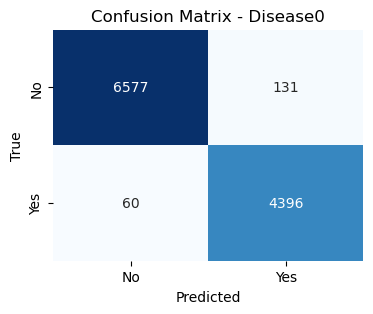

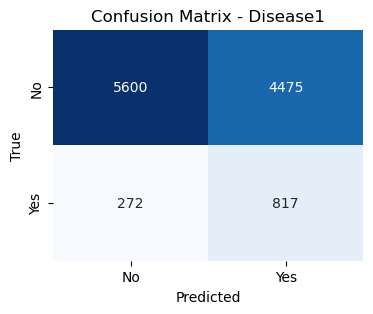

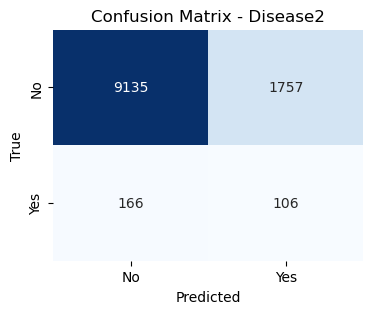

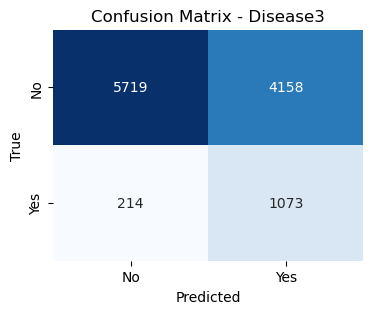

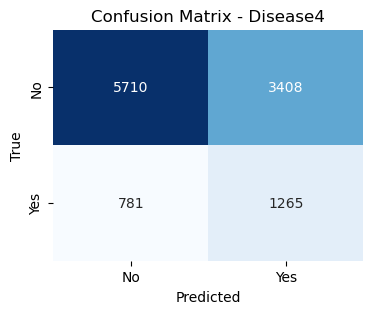

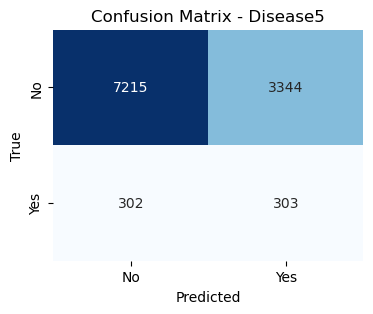

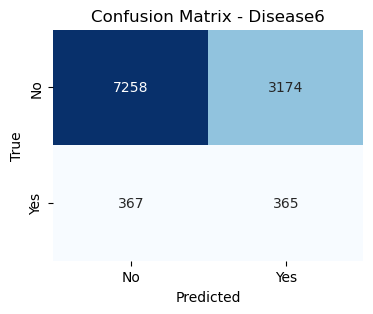

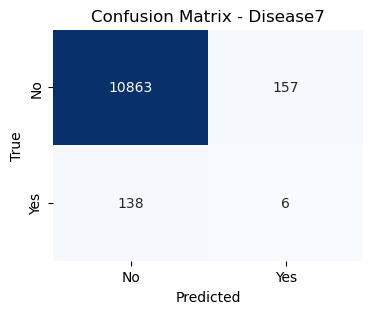

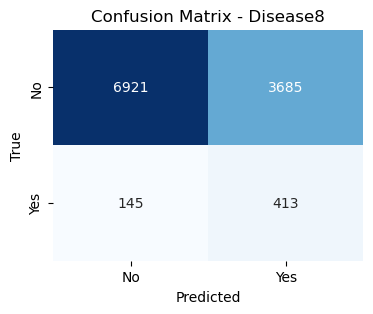

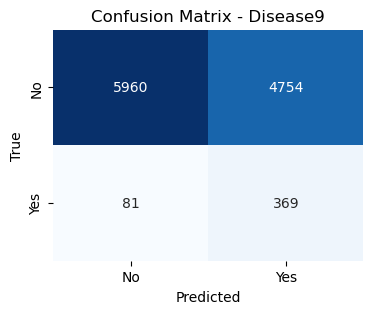

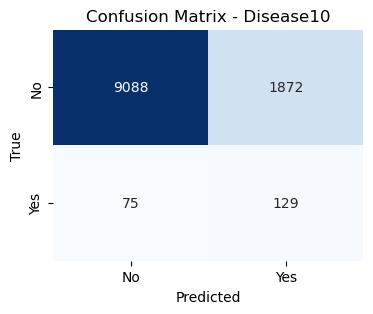

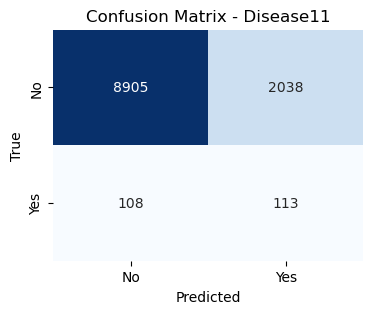

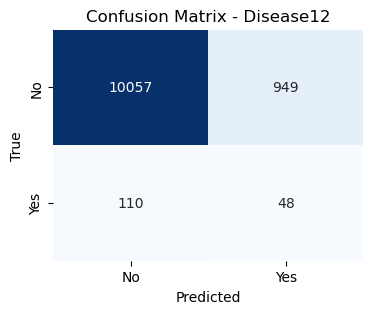

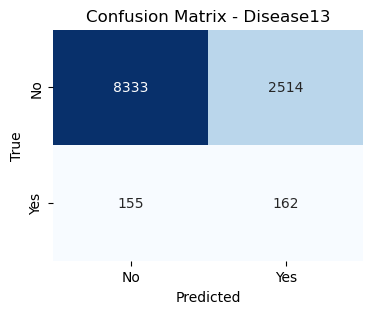

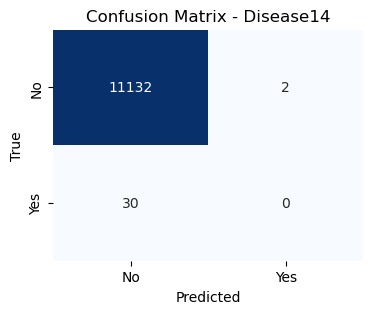

In [58]:
binary_preds = (all_preds > 0.5).astype(int)

disease_names = [f"Disease{i}" for i in range(15)] 

for i, disease in enumerate(disease_names):
    cm = confusion_matrix(all_targets[:, i], binary_preds[:, i])
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {disease}")
    plt.show()


In [ ]:
# The model again is not good enough.
# It outputs too many false positive cases, so we need to adjust the threshold again - 0.3 is definitely too low. 
# We can go back to 0.5, with the new model and weights it should be better.